In [1]:
# H1 — Imports, seed, dataset kökü bulma, keşif
import os, glob, random, json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Kaggle dataset kökü
CAND = glob.glob("/kaggle/input/signature-verification-dataset*")
assert len(CAND)>0, "Add Data → signature-verification-dataset'i ekle."
BASE = CAND[0]
BASE = os.path.join(BASE, "sign_data")
train_dir = os.path.join(BASE, "train")
test_dir  = os.path.join(BASE, "test")
assert os.path.isdir(train_dir) and os.path.isdir(test_dir), "Beklenen sign_data/train & sign_data/test yok."

print("BASE:", BASE)
print("train_dir:", train_dir)
print("test_dir :", test_dir)

# Küçük ağaç çıktısı (bilgi amaçlı)
def sample_tree(root, n=5):
    sub = sorted([d for d in glob.glob(os.path.join(root, "*")) if os.path.isdir(d)])[:n]
    print(f"== {root} (first {n}) ==")
    for d in sub:
        files = sorted(glob.glob(os.path.join(d, "*")))[:5]
        print(" ", os.path.basename(d)+"/ →", [os.path.basename(f) for f in files])

sample_tree(train_dir, 8)
sample_tree(test_dir, 8)


2025-09-26 15:31:48.768867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758900709.074301      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758900709.173658      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


BASE: /kaggle/input/signature-verification-dataset/sign_data
train_dir: /kaggle/input/signature-verification-dataset/sign_data/train
test_dir : /kaggle/input/signature-verification-dataset/sign_data/test
== /kaggle/input/signature-verification-dataset/sign_data/train (first 8) ==
  001/ → ['001_01.PNG', '001_02.PNG', '001_03.PNG', '001_04.PNG', '001_05.PNG']
  001_forg/ → ['0119001_01.png', '0119001_02.png', '0119001_03.png', '0119001_04.png', '0201001_01.png']
  002/ → ['002_01.PNG', '002_02.PNG', '002_03.PNG', '002_04.PNG', '002_05.PNG']
  002_forg/ → ['0108002_01.png', '0108002_02.png', '0108002_03.png', '0108002_04.png', '0110002_01.png']
  003/ → ['003_01.PNG', '003_02.PNG', '003_03.PNG', '003_04.PNG', '003_05.PNG']
  003_forg/ → ['0121003_01.png', '0121003_02.png', '0121003_03.png', '0121003_04.png', '0126003_01.png']
  004/ → ['004_01.PNG', '004_02.PNG', '004_03.PNG', '004_04.PNG', '004_05.PNG']
  004_forg/ → ['0103004_02.png', '0103004_03.png', '0103004_04.png', '0105004_01.png

In [2]:
# H2 — Klasörleri DataFrame'e çevir (forged=0, genuine=1), stratified 70/15/15
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def collect_df(root):
    paths, labels = [], []
    people = sorted([p for p in glob.glob(os.path.join(root, "*")) if os.path.isdir(p)])
    for person_dir in people:
        name = os.path.basename(person_dir).lower()
        # "xxx_forg" klasörleri sahte; diğerleri gerçek
        label = 0 if name.endswith("_forg") else 1
        files = [f for f in glob.glob(os.path.join(person_dir, "*")) if os.path.splitext(f)[1].lower() in IMG_EXTS]
        paths += files
        labels += [label]*len(files)
    return pd.DataFrame({"path": paths, "label": labels})

df_train_all = collect_df(train_dir)
df_test_all  = collect_df(test_dir)

# iki kökü birleştir → train/val/test’i random stratified bölelim (70/15/15)
df_all = pd.concat([df_train_all, df_test_all], axis=0).reset_index(drop=True)
assert len(df_all)>0, "Görüntü bulunamadı."

train_df, tmp_df = train_test_split(df_all, test_size=0.30, stratify=df_all["label"], random_state=SEED)
val_df,   test_df= train_test_split(tmp_df,  test_size=0.50, stratify=tmp_df["label"],  random_state=SEED)

def dist(d): 
    return d['label'].value_counts(normalize=True).rename(index={0:'forged',1:'genuine'}).round(3).to_dict()

print("Boyutlar → train/val/test:", len(train_df), len(val_df), len(test_df))
print("Dağılım → train:", dist(train_df), "  val:", dist(val_df), "  test:", dist(test_df))

class_names = ['forged','genuine']  # 0,1 sırası


Boyutlar → train/val/test: 1504 322 323
Dağılım → train: {'genuine': 0.53, 'forged': 0.47}   val: {'genuine': 0.531, 'forged': 0.469}   test: {'genuine': 0.529, 'forged': 0.471}


In [3]:
# H3 — tf.data (augment sadece train), cache+prefetch
IMG_SIZE = (224,224)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

# Data augment (hafif-orta)
data_aug = keras.Sequential([
    keras.layers.RandomRotation(0.02, fill_mode='nearest'),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.05,0.05, fill_mode='nearest'),
    keras.layers.RandomContrast(0.1),
])

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)/255.0
    return img

def make_ds(df, augment=False, shuffle=False):
    paths = df['path'].values
    labels= df['label'].values.astype('int32')
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED, reshuffle_each_iteration=True)
    def _map(p,l):
        x = decode_img(p)
        if augment:
            x = data_aug(x, training=True)
        return x, l
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds     = make_ds(train_df, augment=True,  shuffle=True)
val_ds       = make_ds(val_df,   augment=False, shuffle=False)
test_ds      = make_ds(test_df,  augment=False, shuffle=False)
train_ds_noa = make_ds(train_df, augment=False, shuffle=True)  # Grad-CAM için pür veri


2025-09-26 15:32:06.385535: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# H4 — Baseline CNN (küçük model)
def build_baseline():
    inputs = keras.Input(shape=IMG_SIZE+(3,))
    x = inputs
    for f in [32,64,128]:
        x = keras.layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D()(x)
        x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(2, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="baseline_cnn")

baseline = build_baseline()
baseline.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

CKPT_BASE = "baseline_best.h5"
cbs = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(CKPT_BASE, monitor="val_loss", save_best_only=True),
]
hist = baseline.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cbs, verbose=1)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.7397 - loss: 0.5446 - val_accuracy: 0.5311 - val_loss: 0.8916
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8712 - loss: 0.3301 - val_accuracy: 0.5311 - val_loss: 0.7767
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9165 - loss: 0.2297 - val_accuracy: 0.5311 - val_loss: 1.7209
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.9103 - loss: 0.2410 - val_accuracy: 0.5311 - val_loss: 2.4662
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9336 - loss: 0.1835 - val_accuracy: 0.5311 - val_loss: 4.8841
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9293 - loss: 0.2139 - val_accuracy: 0.5311 - val_loss: 3.9678
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9528 - loss: 0.1422 - val_accuracy: 0.5093 - val_loss: 1.1070



== Baseline (Test) @0.5 ==
              precision    recall  f1-score   support

      forged     0.0000    0.0000    0.0000       152
     genuine     0.5294    1.0000    0.6923       171

    accuracy                         0.5294       323
   macro avg     0.2647    0.5000    0.3462       323
weighted avg     0.2803    0.5294    0.3665       323

ROC-AUC (genuine): 0.9829947676208064


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


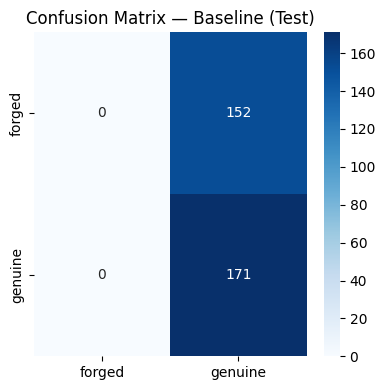

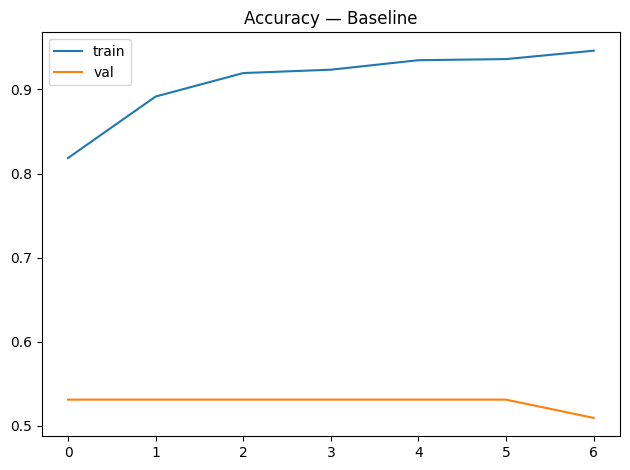

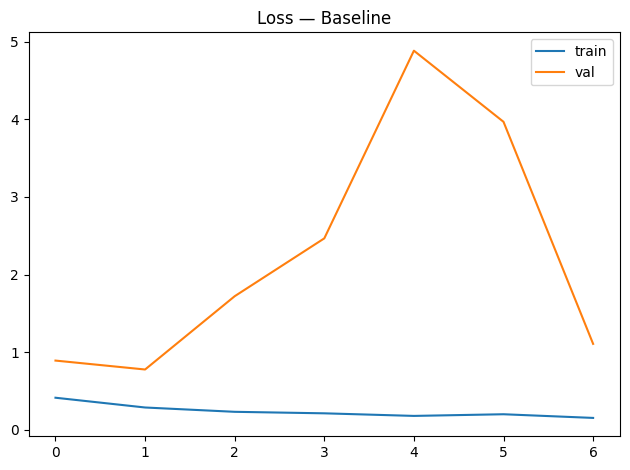

In [5]:
# H5 — Baseline raporlar
def eval_and_plot(model, ds, title):
    # y_true, y_prob
    y_true, y_prob = [], []
    for xb, yb in ds:
        p = model.predict(xb, verbose=0)
        y_prob.append(p[:,1])  # genuine olasılığı
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true)
    y_prob = np.concatenate(y_prob)
    y_pred = (y_prob>=0.5).astype(int)

    print(f"\n== {title} @0.5 ==")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    try:
        print("ROC-AUC (genuine):", roc_auc_score(y_true, y_prob))
    except:
        pass
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix — {title}")
    plt.tight_layout(); plt.show()

eval_and_plot(baseline, test_ds, "Baseline (Test)")

# Eğitim eğrileri
def plot_curves(h, tag):
    plt.figure(); plt.plot(h.history['accuracy']); plt.plot(h.history['val_accuracy'])
    plt.title(f'Accuracy — {tag}'); plt.legend(['train','val']); plt.tight_layout(); plt.show()
    plt.figure(); plt.plot(h.history['loss']); plt.plot(h.history['val_loss'])
    plt.title(f'Loss — {tag}'); plt.legend(['train','val']); plt.tight_layout(); plt.show()

plot_curves(hist, "Baseline")


Grad-CAM katmanı: conv2d_2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_5']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


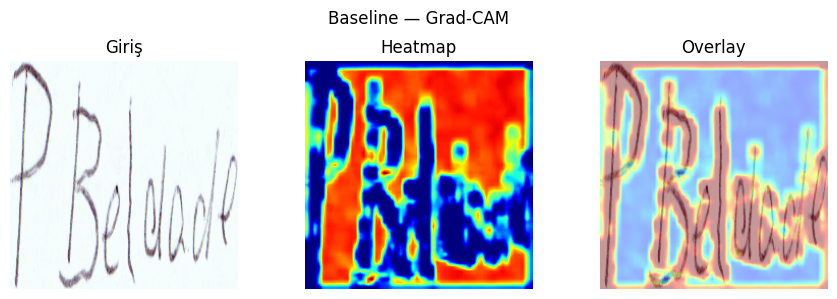

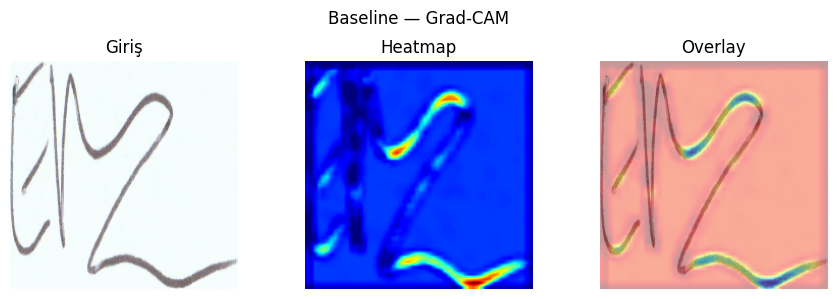

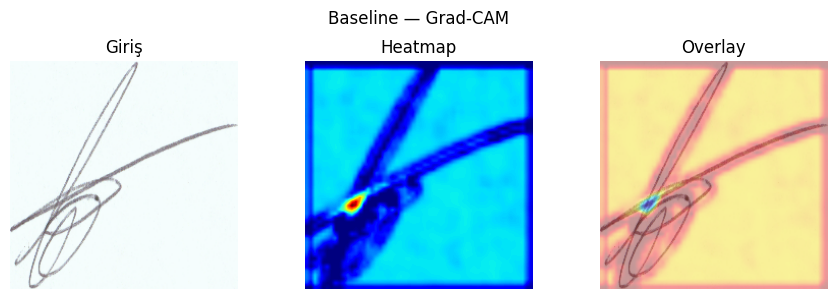

In [6]:
# H6 — Grad-CAM (robust)
import cv2

def gradcam_heatmap(model, img_tensor, layer_name):
    # softmax model: logits = son katmandan önceki? Biz doğrudan softmax üzerinden gradient alacağız
    # (tf.GradientTape ile güvenli cast/indeks düzeltmeleri)
    grad_model = keras.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        class_idx = tf.argmax(preds, axis=-1)
        # gather_nd için tip eşitle
        batch_idx = tf.range(tf.shape(preds)[0], dtype=class_idx.dtype)
        idx = tf.stack([batch_idx, class_idx], axis=1)
        gathered = tf.gather_nd(preds, tf.cast(idx, tf.int32))
    grads = tape.gradient(gathered, conv_out)
    if grads is None:
        return None
    pooled = tf.reduce_mean(grads, axis=(1,2), keepdims=True)
    heat = tf.nn.relu(tf.reduce_sum(pooled * conv_out, axis=-1))
    heat = heat[0].numpy()
    if np.max(heat) <= 1e-12:
        return None
    heat = (heat - heat.min())/(heat.max()-heat.min()+1e-12)
    return heat

# bir-iki örnek göster
last_conv = [l.name for l in baseline.layers if isinstance(l, keras.layers.Conv2D)][-1]
print("Grad-CAM katmanı:", last_conv)

shown = 0
for xb, yb in test_ds.take(1):
    for i in range(min(3, xb.shape[0])):
        img = xb[i:i+1]
        heat = gradcam_heatmap(baseline, img, last_conv)
        base = (img[0].numpy()*255).astype(np.uint8)
        if base.shape[-1]==1: base = np.repeat(base, 3, axis=-1)
        if heat is not None:
            hm = cv2.resize(heat, (base.shape[1], base.shape[0]))
            cmap = np.uint8(255*hm); cmap = cv2.applyColorMap(cmap, cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(base, 0.6, cmap, 0.4, 0)
            plt.figure(figsize=(9,3))
            plt.subplot(1,3,1); plt.imshow(base); plt.title("Giriş"); plt.axis("off")
            plt.subplot(1,3,2); plt.imshow(hm, cmap='jet'); plt.title("Heatmap"); plt.axis("off")
            plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
            plt.suptitle("Baseline — Grad-CAM")
            plt.tight_layout(); plt.show()
        shown += 1
    break


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5338 - loss: 0.6967 - val_accuracy: 0.5311 - val_loss: 0.7027
Epoch 2/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5129 - loss: 0.7101 - val_accuracy: 0.4689 - val_loss: 0.7218
Epoch 3/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5109 - loss: 0.7129 - val_accuracy: 0.6491 - val_loss: 0.6870
Epoch 4/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5278 - loss: 0.6992 - val_accuracy: 0.5559 - val_loss: 0.6859
Epoch 5/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5402 - loss: 0.6931 - val_accuracy: 0.4689 - val_loss: 0.6888
Epoch 6/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5141 - loss: 0.7007 - val_accuracy: 0.5311 - val_loss: 0.6882
Epoch 7/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4879 - loss: 0.7235 - val_accuracy: 0.5839 - val_loss: 0.6776
Epoch 8/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5240 - loss

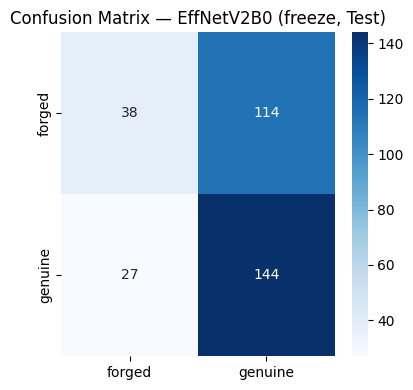

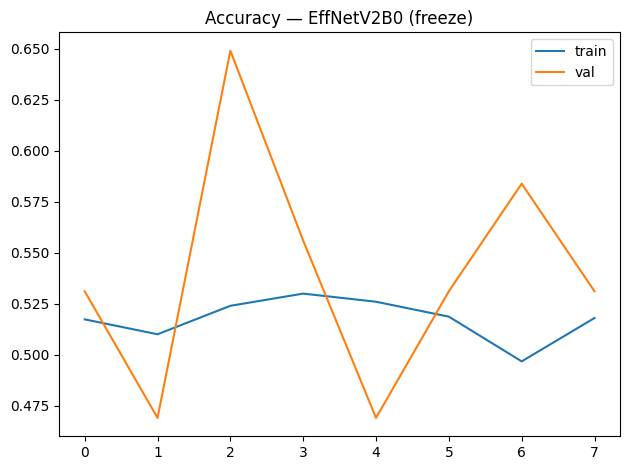

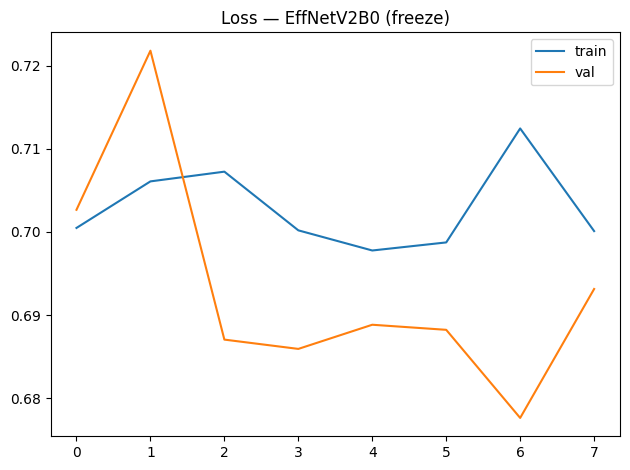

In [7]:
# H7 — EffNetV2B0 (freeze aşaması)
base = keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,)
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE+(3,))
x = inputs
x = base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)

effnet = keras.Model(inputs, outputs, name="effnetv2b0_sig")

effnet.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

CKPT_TL = "tl_best.h5"
cbs_tl = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(CKPT_TL, monitor='val_loss', save_best_only=True)
]
hist_tl = effnet.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=cbs_tl, verbose=1)

eval_and_plot(effnet, test_ds, "EffNetV2B0 (freeze, Test)")
plot_curves(hist_tl, "EffNetV2B0 (freeze)")


Val tuned threshold (F1-genuine max): 0.781
Val ROC-AUC (genuine): 0.9670036017195306

== Baseline (Test) @tuned threshold ==
              precision    recall  f1-score   support

      forged     0.9375    0.8882    0.9122       152
     genuine     0.9050    0.9474    0.9257       171

    accuracy                         0.9195       323
   macro avg     0.9213    0.9178    0.9189       323
weighted avg     0.9203    0.9195    0.9193       323



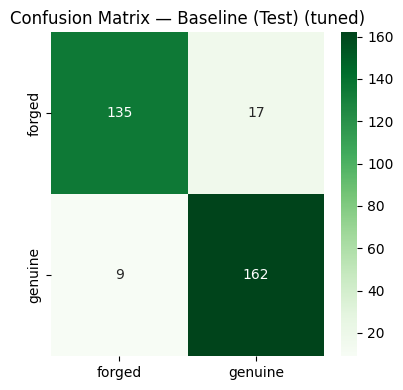

Val tuned threshold (F1-genuine max): 0.509
Val ROC-AUC (genuine): 0.7441230006583788

== EffNetV2B0 (Test) @tuned threshold ==
              precision    recall  f1-score   support

      forged     0.5625    0.2961    0.3879       152
     genuine     0.5597    0.7953    0.6570       171

    accuracy                         0.5604       323
   macro avg     0.5611    0.5457    0.5225       323
weighted avg     0.5610    0.5604    0.5304       323



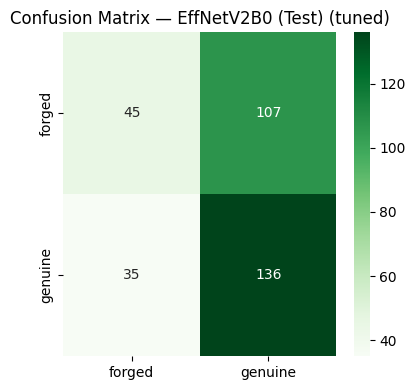

In [8]:
# H8 — Eşik ayarı (val → best_th), testte uygula
def collect_probs(ds, model):
    y_true, y_prob = [], []
    for xb, yb in ds:
        p = model.predict(xb, verbose=0)
        y_prob.append(p[:,1])
        y_true.append(yb.numpy())
    return np.concatenate(y_true), np.concatenate(y_prob)

def tune_threshold_on_val(model):
    yv, pv = collect_probs(val_ds, model)
    prec, rec, thr = precision_recall_curve(yv, pv)  # 1=genuine
    f1 = 2*prec*rec/(prec+rec+1e-8)
    best_idx = np.nanargmax(f1)
    best_th = thr[max(best_idx-1, 0)]
    print(f"Val tuned threshold (F1-genuine max): {best_th:.3f}")
    print("Val ROC-AUC (genuine):", roc_auc_score(yv, pv))
    return best_th

def report_with_threshold(model, ds, th, tag):
    yt, pt = collect_probs(ds, model)
    yp = (pt>=th).astype(int)
    print(f"\n== {tag} @tuned threshold ==")
    print(classification_report(yt, yp, target_names=class_names, digits=4))
    cm = confusion_matrix(yt, yp, labels=[0,1])
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix — {tag} (tuned)")
    plt.tight_layout(); plt.show()

# Baseline & EffNet için ayrı ayrı eşik ve test raporu
th_base = tune_threshold_on_val(baseline)
report_with_threshold(baseline, test_ds, th_base, "Baseline (Test)")

th_eff  = tune_threshold_on_val(effnet)
report_with_threshold(effnet, test_ds, th_eff, "EffNetV2B0 (Test)")


class_weight: {0: 1.0636492220575415, 1: 0.9435382685009817}
Epoch 1/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.6912 - loss: 0.5506 - val_accuracy: 0.5311 - val_loss: 0.8541
Epoch 2/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.9264 - loss: 0.1963 - val_accuracy: 0.5466 - val_loss: 0.6685
Epoch 3/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.9708 - loss: 0.1047 - val_accuracy: 0.8230 - val_loss: 0.3976
Val tuned threshold (F1-genuine max): 0.160
Val ROC-AUC (genuine): 0.9673908833894891

== EffNetV2B0 (FT, Test) @tuned threshold ==
              precision    recall  f1-score   support

      forged     0.8720    0.9408    0.9051       152
     genuine     0.9434    0.8772    0.9091       171

    accuracy                         0.9071       323
   macro avg     0.9077    0.9090    0.9071       323
weighted avg     0.9098    0.9071    0.9072       323



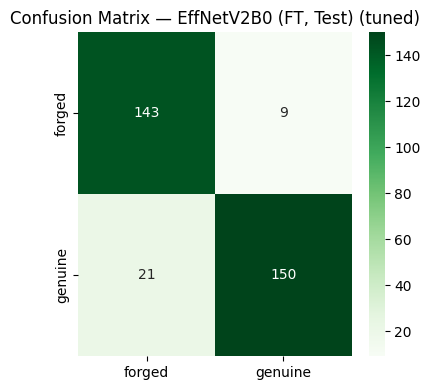

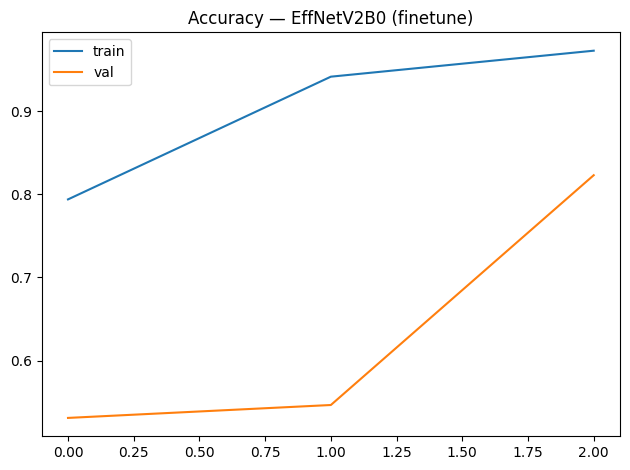

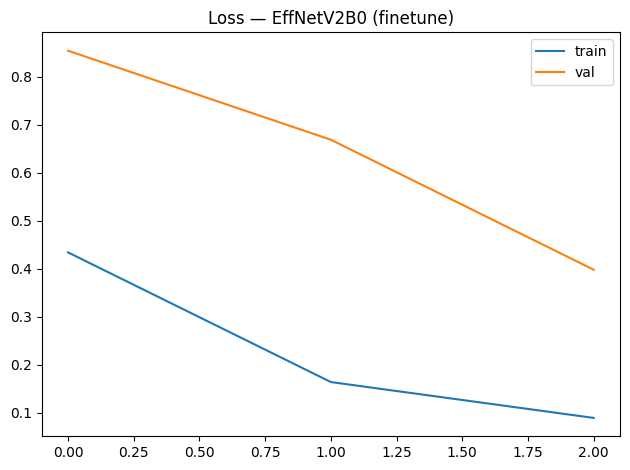

In [9]:
# H9 — Kısa Fine-Tune (son katmanları aç, BN hariç), class_weight
from collections import Counter

cnt = Counter(train_df['label'].tolist())
total = sum(cnt.values())
w_for = total/(2.0*cnt[0]+1e-8)   # 0=forged
w_gen = total/(2.0*cnt[1]+1e-8)   # 1=genuine
class_weight = {0: w_for, 1: w_gen}
print("class_weight:", class_weight)

# Son ~20 katmanı (BN hariç) aç
for l in effnet.layers[-20:]:
    if not isinstance(l, keras.layers.BatchNormalization):
        l.trainable = True

effnet.compile(optimizer=keras.optimizers.Adam(1e-4),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

cb_ft = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
hist_ft = effnet.fit(train_ds, validation_data=val_ds, epochs=3,
                     class_weight=class_weight, callbacks=cb_ft, verbose=1)

# FT sonrası tuned threshold ile yeniden değerlendir
th_eff_ft = tune_threshold_on_val(effnet)
report_with_threshold(effnet, test_ds, th_eff_ft, "EffNetV2B0 (FT, Test)")
plot_curves(hist_ft, "EffNetV2B0 (finetune)")


In [10]:
# H10 — /kaggle/working/outputs altına kayıt
OUTDIR = "/kaggle/working/outputs"
os.makedirs(OUTDIR, exist_ok=True)

def quick_save_report(model, name, ds):
    yt, yp = collect_probs(ds, model)
    yhat = (yp>=0.5).astype(int)
    rep = classification_report(yt, yhat, target_names=class_names, digits=4)
    with open(os.path.join(OUTDIR, f"report_{name}_@0.5.txt"), "w") as f:
        f.write(rep)
    try:
        with open(os.path.join(OUTDIR, f"roc_{name}.txt"), "w") as f:
            f.write(str(roc_auc_score(yt, yp)))
    except:
        pass
    cm = confusion_matrix(yt, yhat, labels=[0,1])
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix — {name} @0.5")
    plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"cm_{name}_@0.5.png"), dpi=150); plt.close()

quick_save_report(baseline, "baseline", test_ds)
quick_save_report(effnet,   "effnetv2b0_ft", test_ds)

# Eğitim eğrilerini kaydet
def save_curves(h, tag):
    plt.figure(); plt.plot(h.history['accuracy']); plt.plot(h.history['val_accuracy'])
    plt.title(f"Accuracy — {tag}"); plt.legend(['train','val']); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"acc_{tag}.png"), dpi=150); plt.close()

    plt.figure(); plt.plot(h.history['loss']); plt.plot(h.history['val_loss'])
    plt.title(f"Loss — {tag}"); plt.legend(['train','val']); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"loss_{tag}.png"), dpi=150); plt.close()

save_curves(hist,    "baseline")
save_curves(hist_tl, "effnet_freeze")
save_curves(hist_ft, "effnet_finetune")

# Model kartı
model_card = {
    "img_size": list(IMG_SIZE),
    "classes": class_names,
    "splits": {"train": len(train_df), "val": len(val_df), "test": len(test_df)},
    "baseline_ckpt": "baseline_best.h5",
    "tl_ckpt": "tl_best.h5",
    "thresholds": {
        "baseline_best_valF1_th": float(th_base),
        "effnet_freeze_best_valF1_th": float(th_eff),
        "effnet_ft_best_valF1_th": float(th_eff_ft)
    },
    "notes": "Stratified 70/15/15; Augment only on train; TL freeze+FT(+class_weight); Threshold tuning (val F1-genuine)."
}
with open(os.path.join(OUTDIR, "model_card.json"), "w") as f:
    json.dump(model_card, f, indent=2)

print("Kaydedildi →", OUTDIR)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Kaydedildi → /kaggle/working/outputs
